# Clustering : K-Means : Uber Pickups

This is data of Uber pickups in New York City.  
The data is from this [kaggle competition](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city).

Sample data looks like this
```
"Date_Time","Lat","Lon","Base"
"4/1/2014 0:11:00",40.769,-73.9549,"B02512"
"4/1/2014 0:17:00",40.7267,-74.0345,"B02512"
"4/1/2014 0:21:00",40.7316,-73.9873,"B02512"
"4/1/2014 0:28:00",40.7588,-73.9776,"B02512"
```

In [6]:
try:
    spark
except NameError:
    # initialize Spark Session
    import os
    import sys
    top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
    if top_dir not in sys.path:
        sys.path.append(top_dir)

    from init_spark import init_spark
    spark = init_spark()

print('Spark UI running on port ' + spark.sparkContext.uiWebUrl.split(':')[2])
spark

Spark UI running on port 4040


## Step 1: Load the Data
We will also specify schema to reduce loading time

In [7]:
# file to read

## sample file with 10,000 records
data_location="../data/uber-nyc/uber-sample-10k.csv"
# data_location = 's3://elephantscale-public/data/uber-nyc/uber-sample-10k.csv'
# data_location = 'gs://elephantscale-public/data/uber-nyc/uber-sample-10k.csv'

## larger file with about 500k records
#data_location = "../data/uber-nyc/uber-raw-data-apr14.csv.gz"
# data_location = 's3://elephantscale-public/data/uber-nyc/uber-raw-data-apr14.csv.gz'
# data_location = 'gs://elephantscale-public/data/uber-nyc/uber-raw-data-apr14.csv.gz'

## all data
# data_location = "../data/uber-nyc/*csv.gz"


In [8]:
from pyspark.sql.types import StringType, FloatType, StructField, StructType

pickup_time_field = StructField("pickup_time", StringType(), True)
lat_field = StructField("Lat", FloatType(), True)
lon_field = StructField("Lon", FloatType(), True)
base_field = StructField("Base", StringType(), True)

schema = StructType([pickup_time_field, lat_field, lon_field, base_field])


In [9]:
%%time
uber_pickups = spark.read.option("header", "true").schema(schema).csv(data_location)

CPU times: user 3.9 ms, sys: 0 ns, total: 3.9 ms
Wall time: 1.25 s


In [10]:
records_count_total = uber_pickups.count()
print("read {:,} records".format(records_count_total))
uber_pickups.printSchema()
uber_pickups.show(10)

read 9,999 records
root
 |-- pickup_time: string (nullable = true)
 |-- Lat: float (nullable = true)
 |-- Lon: float (nullable = true)
 |-- Base: string (nullable = true)

+------------------+-------+--------+------+
|       pickup_time|    Lat|     Lon|  Base|
+------------------+-------+--------+------+
|9/25/2014 15:28:00|40.7633|-73.9402|B02598|
|  9/5/2014 3:50:00|40.7441|-74.0067|B02617|
|9/24/2014 13:39:00|40.7408|-73.9916|B02617|
| 9/18/2014 0:31:00|40.7396|-74.0023|B02617|
|9/20/2014 11:22:00|40.7441|-73.9919|B02617|
|9/26/2014 17:03:00|40.6943|-73.9239|B02764|
|9/24/2014 18:59:00|40.8526|-73.8435|B02617|
|9/23/2014 16:33:00|40.7146|-74.0087|B02617|
|9/17/2014 22:16:00|40.7751|-73.9092|B02682|
| 9/6/2014 11:13:00|40.7191|-73.9754|B02682|
+------------------+-------+--------+------+
only showing top 10 rows



## Step 2: Cleanup data
make sure our data is clean

In [11]:
uber_pickups_clean = uber_pickups.na.drop(subset=['Lat', 'Lon'])
records_count_clean = uber_pickups_clean.count()

print ("cleaned records {:,},  dropped {:,}".format(records_count_clean,  (records_count_total - records_count_clean)))

cleaned records 9,999,  dropped 0


## Step 3 : Create Feature Vectors

In [12]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Lat", "Lon"], outputCol="features")
featureVector = assembler.transform(uber_pickups_clean)
featureVector.show()

+------------------+-------+--------+------+--------------------+
|       pickup_time|    Lat|     Lon|  Base|            features|
+------------------+-------+--------+------+--------------------+
|9/25/2014 15:28:00|40.7633|-73.9402|B02598|[40.7633018493652...|
|  9/5/2014 3:50:00|40.7441|-74.0067|B02617|[40.7440986633300...|
|9/24/2014 13:39:00|40.7408|-73.9916|B02617|[40.7407989501953...|
| 9/18/2014 0:31:00|40.7396|-74.0023|B02617|[40.7396011352539...|
|9/20/2014 11:22:00|40.7441|-73.9919|B02617|[40.7440986633300...|
|9/26/2014 17:03:00|40.6943|-73.9239|B02764|[40.6943016052246...|
|9/24/2014 18:59:00|40.8526|-73.8435|B02617|[40.8526000976562...|
|9/23/2014 16:33:00|40.7146|-74.0087|B02617|[40.714599609375,...|
|9/17/2014 22:16:00|40.7751|-73.9092|B02682|[40.7751007080078...|
| 9/6/2014 11:13:00|40.7191|-73.9754|B02682|[40.7191009521484...|
| 9/6/2014 11:43:00|40.7242|-73.9829|B02617|[40.7242012023925...|
|  9/7/2014 1:36:00| 40.751|-73.9829|B02764|[40.7509994506835...|
|9/13/2014

## Step 4: Running Kmeans

Now it's time to run kmeans on the resultant dataframe.  We don't know what value of k to use, so let's just start with k=4.  This means we will cluster into four groups.

We will fit a model to the data, and then train it.

In [13]:
from pyspark.ml.clustering import KMeans

num_clusters = 4
kmeans = KMeans().setK(num_clusters).setSeed(1)

In [14]:
%%time
model = kmeans.fit(featureVector)

CPU times: user 2.21 ms, sys: 4.36 ms, total: 6.58 ms
Wall time: 1.91 s


In [15]:
wssse = model.computeCost(featureVector)
print ("num_clusters = {},  WSSSE = {:,}".format(num_clusters, wssse))

num_clusters = 4,  WSSSE = 18.956462176856782


## Step 6: Let's find the best K - Hyperparameter tuning

Let's try iterating and plotting over values of k, so we can practice using the elbow method.


In [16]:
import time 

kvals = []
wssses = []

# For lop to run over and over again.
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1)
    t1 = time.perf_counter()
    model = kmeans.fit(featureVector)
    t2 = time.perf_counter()
    wssse = model.computeCost(featureVector)
    print ("k={},  wssse={},  time took {:,.2f} ms".format(k,wssse, ((t2-t1)*1000)))
    kvals.append(k)
    wssses.append(wssse)

k=2,  wssse=43.81037100445453,  time took 497.20 ms
k=3,  wssse=23.405478495577455,  time took 746.76 ms
k=4,  wssse=18.956462176856782,  time took 670.27 ms
k=5,  wssse=15.777779078551966,  time took 616.79 ms
k=6,  wssse=12.130705111792851,  time took 558.36 ms
k=7,  wssse=9.694708813401633,  time took 574.23 ms
k=8,  wssse=11.17531014847885,  time took 468.06 ms
k=9,  wssse=8.496342099692702,  time took 598.57 ms


In [17]:
import pandas as pd
df = pd.DataFrame({'k': kvals, 'wssse':wssses})
df

,k,wssse
0,2,43.810371
1,3,23.405478
2,4,18.956462
3,5,15.777779
4,6,12.130705
5,7,9.694709
6,8,11.175310
7,9,8.496342


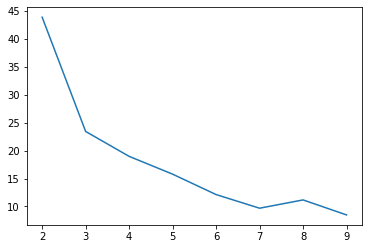

In [18]:
%matplotlib inline
from matplotlib import pyplot

pyplot.plot(kvals, wssses)

## Step 7 : Let's run K-Means with the best K we have choosen

In [19]:
num_clusters = 6
kmeans = KMeans().setK(num_clusters).setSeed(1)

t1 = time.perf_counter()
model = kmeans.fit(featureVector)
t2 = time.perf_counter()

wssse = model.computeCost(featureVector)


print("Kmeans : {} clusters computed in {:,.2f} ms".format( num_clusters,  ((t2-t1)*1000)))
print ("num_clusters = {},  WSSSE = {:,}".format(num_clusters, wssse))

Kmeans : 6 clusters computed in 474.92 ms
num_clusters = 6,  WSSSE = 12.130705111792851


In [20]:
t1 = time.perf_counter()
predicted = model.transform(featureVector)
t2 = time.perf_counter()

print ("{:,} records clustered in {:,.2f} ms".format(predicted.count(), ((t2-t1)*1000) ))

predicted.show()

9,999 records clustered in 25.30 ms
+------------------+-------+--------+------+--------------------+----------+
|       pickup_time|    Lat|     Lon|  Base|            features|prediction|
+------------------+-------+--------+------+--------------------+----------+
|9/25/2014 15:28:00|40.7633|-73.9402|B02598|[40.7633018493652...|         3|
|  9/5/2014 3:50:00|40.7441|-74.0067|B02617|[40.7440986633300...|         0|
|9/24/2014 13:39:00|40.7408|-73.9916|B02617|[40.7407989501953...|         0|
| 9/18/2014 0:31:00|40.7396|-74.0023|B02617|[40.7396011352539...|         0|
|9/20/2014 11:22:00|40.7441|-73.9919|B02617|[40.7440986633300...|         0|
|9/26/2014 17:03:00|40.6943|-73.9239|B02764|[40.6943016052246...|         2|
|9/24/2014 18:59:00|40.8526|-73.8435|B02617|[40.8526000976562...|         1|
|9/23/2014 16:33:00|40.7146|-74.0087|B02617|[40.714599609375,...|         0|
|9/17/2014 22:16:00|40.7751|-73.9092|B02682|[40.7751007080078...|         1|
| 9/6/2014 11:13:00|40.7191|-73.9754|B02

## Step 8 : Print Cluster Center and Size

In [21]:
cluster_count = predicted.groupby("prediction").count().orderBy("prediction")
cluster_count.show()
index = 0
for c in model.clusterCenters():
    print(index, c)
    index = index+1


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 4384|
|         1|  483|
|         2| 1352|
|         3| 3369|
|         4|  321|
|         5|   90|
+----------+-----+

0 [ 40.73266776 -73.99749977]
1 [ 40.80127268 -73.87188312]
2 [ 40.68783773 -73.9643646 ]
3 [ 40.76861717 -73.96999715]
4 [ 40.67274573 -73.76315434]
5 [ 40.7050081  -74.19973195]


## Step 9 : Ploting time!
We are going to plot the results now.  
Since we are dealing with GEO co-ordinates, let's use Google Maps!  

Go to the following URL :  
[https://jsfiddle.net/sujee/omypetfu/](https://jsfiddle.net/sujee/omypetfu/)

- Run the code cell below
- copy paste the output into Javascript section of the JSFiddle Editor (lower left)
- and click 'Run'  (top nav bar)
- Click on 'tidy' (top nav bar)  to cleanup code

See the following image 

<img src="../assets/images/kmeans_uber_trips_map.png" style="border: 5px solid grey ; max-width:100%;" />

You will be rewarded with a beautiful map of clusters on Google Maps

<img src="../assets/images/Kmeans_uber_trips.png" style="border: 5px solid grey ; max-width:100%;" />

Optional
- You can 'fork' the snippet and keep tweaking

In [22]:
### generate Javascript
s1 = "var clusters = {"

s2 = ""

prediction_count = predicted.groupby("prediction").count().orderBy("prediction").select("count").collect()
total_count = 0
cluster_centers = model.clusterCenters()
for i in range(0, num_clusters):
    count = prediction_count[i]["count"]
    lat = cluster_centers[i][0]
    lng = cluster_centers[i][1]
    total_count = total_count + count
    if (i > 0):
        s2 = s2 + ","
    s2 = s2 + " {}: {{ center: {{ lat: {}, lng: {} }}, count: {} }}".\
        format(i, lat, lng, count)
    #s2 = s2 + "{}: {{  center: {{ }}, }}".format(i)

s3 = s1 + s2 + "};"

s4 = """
function initMap() {
  // Create the map.
  var map = new google.maps.Map(document.getElementById('map'), {
    zoom: 10,
    center: {
      lat: 40.77274573,
      lng: -73.94
    },
    mapTypeId: 'roadmap'
  });

  // Construct the circle for each value in citymap.
  // Note: We scale the area of the circle based on the population.
  for (var cluster in clusters) {
    // Add the circle for this city to the map.
    var cityCircle = new google.maps.Circle({
      strokeColor: '#FF0000',
      strokeOpacity: 0.8,
      strokeWeight: 2,
      fillColor: '#FF0000',
      fillOpacity: 0.35,
      map: map,
      center: clusters[cluster].center,
"""

s5 = "radius: clusters[cluster].count / {} * 100 * 300 }});  }}}}".format(total_count)

# final
s = s3 + s4 + s5

print(s)

var clusters = { 0: { center: { lat: 40.73266775844196, lng: -73.99749977498335 }, count: 4384 }, 1: { center: { lat: 40.80127267601076, lng: -73.87188312435939 }, count: 483 }, 2: { center: { lat: 40.687837733319526, lng: -73.96436460483709 }, count: 1352 }, 3: { center: { lat: 40.76861716703421, lng: -73.96999715244735 }, count: 3369 }, 4: { center: { lat: 40.67274572544751, lng: -73.76315433585384 }, count: 321 }, 5: { center: { lat: 40.705008104112416, lng: -74.19973195393881 }, count: 90 }};
function initMap() {
  // Create the map.
  var map = new google.maps.Map(document.getElementById('map'), {
    zoom: 10,
    center: {
      lat: 40.77274573,
      lng: -73.94
    },
    mapTypeId: 'roadmap'
  });

  // Construct the circle for each value in citymap.
  // Note: We scale the area of the circle based on the population.
  for (var cluster in clusters) {
    // Add the circle for this city to the map.
    var cityCircle = new google.maps.Circle({
      strokeColor: '#FF0000',
  

## Step 10 : Running the script

**Use the dowload script**

```bash
cd   ~/data/uber-nyc
./download-data.sh
```

This will download more data.

As we run on larger dataset, the execution will take longer and Jupyter notebook might time out.  So let's run this in command line / script mode

```bash

$    cd   ~/ml-labs-spark-python/clustering

$    time  ~/spark/bin/spark-submit    --master local[*]  kmeans-uber.py 2> logs

```

Watch the output
